# Summary plots for values of $m_{\phi}$

This notebook makes summary plots, showing the $\mu=1$ exclusion limit for every value of $m_{\phi}$ and decay mode. This script is very similar to summary-ms.ipynb. However, we now keep $m_{\phi}$ fixed and scan through the parameter space of $T$ and $m_s$.

In [6]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
import matplotlib
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import os 
import scipy
import uproot
import glob
import yaml
import json
import math

import mplhep as hep
hep.style.use("CMS")
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.dpi'] = 50
matplotlib.rcParams['figure.facecolor'] = 'white'
np.seterr(divide='ignore', invalid='ignore')

#plt.style.use('physics.mplstyle')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [23]:
era = 2018
decaymode = 'generic'
mphi = 3.
lumis = {
    2016 : 36.3, #36.308
    2017 : 41.5, #41.471 
    2018 : 59.8, #59.817
    'combined' : 59.8+41.5+ 36.3
}

decays = {
    'hadronic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$ with BR=15,15,70%",
    'leptonic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$ with BR=40,40,20%",
    'generic' : r"$A^' \rightarrow \pi^{+}\pi^{-}$ with BR=100%"
}
                     

In [24]:
def get_limits(fn): 
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit]) 
    
def get_SUEP_file(Mass=125, mdark=2, t=1, decay="darkPho", path="./"): 
    if t < 10:
        tem = "{0:.2f}".format(t)
    else:
        tem = "{0:.1f}".format(t)
    tem = str(tem).replace(".","p")
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT1000_T{}_mS{:.3f}_mPhi{:.3f}_T{:.3f}_mode{}_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root".format(tem, Mass, mdark, t, decay)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
     
def log_interp1d(xx, yy, kind='linear'): # Returns a linear interpolation through log(x) and log(y)
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp 


def log_interp2d(xx, yy, zz, method='nearest'): # Returns a linear interpolation through log(x) and log(y)
    logx = np.log(xx)
    logy = np.log(yy)
    logz = np.log(zz)
    points = np.concatenate(((logx.reshape((len(logx),1)), logy.reshape(len(logy),1))), axis=1)
    lin_interp = griddata(points,logz,(logx[None,:], logy[:,None]),method="nearest")
    log_interp = np.power(np.e, lin_interp)
    return log_interp 

def interpLimit(limit, sigma=3):
    x, y = limit.T
    t  = np.linspace(0, 1, len(x))
    t2 = np.linspace(-0.9, 1.2, 100)

    x2 = np.interp(t2, t, x)
    y2 = np.interp(t2, t, y)
    
    x3 = gaussian_filter1d(x2, sigma)
    y3 = gaussian_filter1d(y2, sigma)
    x4 = np.interp(t, t2, x3)
    y4 = np.interp(t, t2, y3)

    return x3, y3

def xs_scale(proc):
    xsec = 1.0
    with open(f"../config/xsections_{era}.json") as file:
            MC_xsecs = json.load(file)
    xsec  = MC_xsecs[proc]["xsec"] # xsection in pb
    # xsec *= MC_xsecs[proc]["kr"] # filter efficiency
    # xsec *= MC_xsecs[proc]["br"] 
    #xsec *= 1000.0 # To change from pb to fb
    assert xsec > 0, "{} has a null cross section!".format(proc)
    return xsec



In [25]:
combine_files = glob.glob("../higgs*{}*.root".format(decaymode))

In [26]:
all_params = []
for file in combine_files:
    file_trim = file.split("HT1000_")[1]
    proc = 'GluGluToSUEP_HT1000_' + file_trim.split('.Asymptotic')[0]
    xsec = xs_scale(proc)
    t = float(file_trim.split("_")[0].replace("p",".")[1:])
    Mass = float(file_trim.split("_")[1][2:])
    mdark = float(file_trim.split("_")[2][4:])
    all_params.append([t,Mass,mdark,xsec])
    


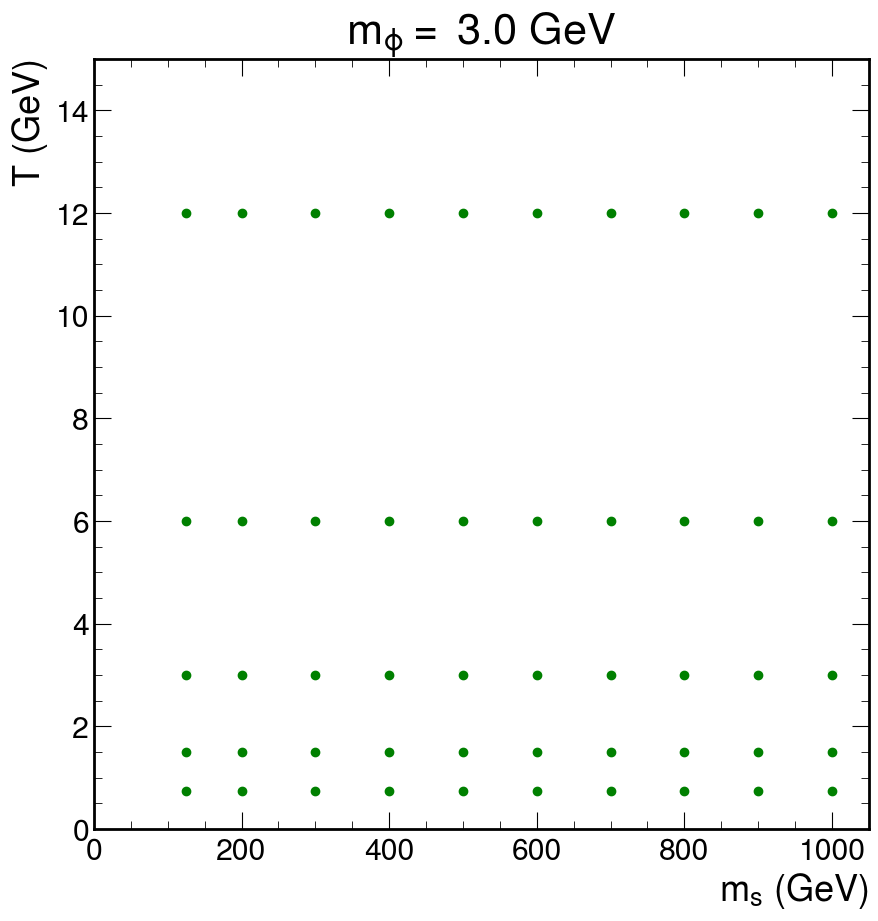

In [27]:
def get_params(mphi=mphi,plot=True): #Returns list of all [MSUEP,T,xsec] for a given phi
    params = []
    for pair in all_params:
        if pair[2] != mphi: continue
        params.append([pair[1],pair[0],pair[3]])

    skip_bad =[]

    for pair in params:
        try:
            limit = get_limits(get_SUEP_file(Mass=pair[0], mdark=mphi ,t=pair[1] ,decay=decaymode))
            if limit.shape == (2,6):
                if plot: plt.scatter(pair[0],pair[1], color="green")
                skip_bad.append(pair)
            else:
                print(get_SUEP_file(Mass=pair[0], mdark=mphi ,t=pair[1] ,decay=decaymode))

                if plot: plt.scatter(pair[0],pair[1], color="blue", alpha=0.5)
        except:
            print(get_SUEP_file(Mass=pair[0], mdark=mphi ,t=pair[1] ,decay=decaymode))
            if plot: plt.scatter(pair[0],pair[1], color="red")

    if plot:
        plt.ylim([0, mphi*5])
        plt.xlim([0, 1050])
        plt.xlabel(r"$m_{s}$ (GeV)", x=1, ha='right')
        plt.ylabel(r"$T$ (GeV)", y=1, ha='right')
        plt.title(r'$m_{{\phi}}=$ {} GeV'.format(mphi))
        plt.show()

    return skip_bad
    
params = get_params(mphi)
# print(params)

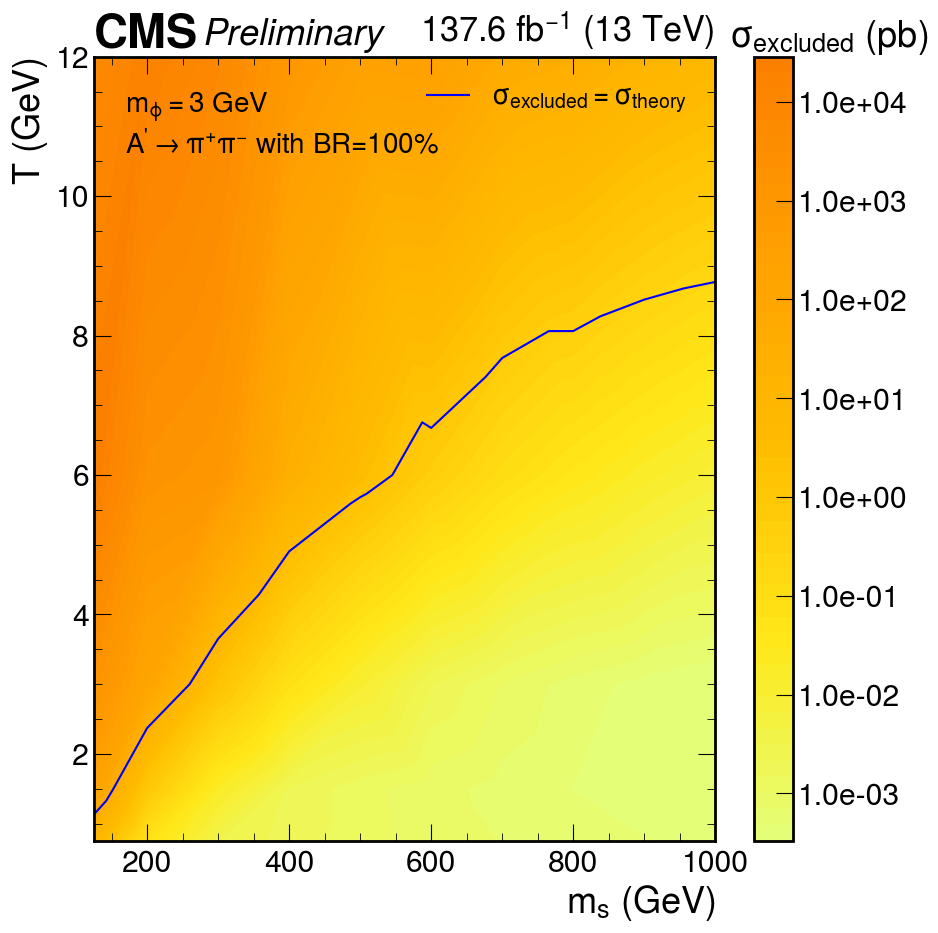

In [36]:
#Plots a 2D limit plot
def plot_SUEP(params=params,unblind=False,tricontour='log'): 
    
    if tricontour not in ['log','lin']: #tricontour decides whether we interpolate through mu ('lin') or log(mu) ('log')
        raise Exception("tricontour should be 'log' or 'lin'")
    
    # Reorganize data

    limit_T = [] # T
    limit_M = [] # SUEP mass
    limit_lm = [] # results for mu
    limit_xs = []
    return_limit = []

    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=pair[0], mdark=mphi ,t=pair[1] ,decay=decaymode))
        limit = limit #* pair[2] # To plot the xsection rather than mu
        if limit.shape == (2, 6):
            limit_lm.append(limit)
            limit_M.append(pair[0])
            limit_T.append(pair[1])
            return_limit.append([pair[0], pair[1], limit[1,2]])
            limit_xs.append(pair[2])
        else: 
            continue

    limit_lm = np.array(limit_lm)
    limit_T = np.array(limit_T)
    limit_M = np.array(limit_M)
    limit_xs = np.array(limit_xs)
    
    
    if tricontour == 'log':
        limit_lm[:,1,:]= np.log10(limit_lm[:,1,:]) # Convert mu to logarithm of mu 
    
    data = pd.DataFrame(
        {
            "mH"  : np.array(limit_T),
            "ma"  : np.array(limit_M),
            "m2s" : np.array(limit_lm)[:,1,0],
            "m1s" : np.array(limit_lm)[:,1,1],
            "exp" : np.array(limit_lm)[:,1,2],
            "p1s" : np.array(limit_lm)[:,1,3],
            "p2s" : np.array(limit_lm)[:,1,4],
            "obs" : np.array(limit_lm)[:,1,5],
            
        }
    )
    
    data['xsec_obs'] = data['obs']+np.log10(limit_xs)
    
   
    # Plot figure and obtain mu=1 (log(mu)=0) lines
        
    plt.figure(figsize=(10,10))
    ax = plt.gca()

    if tricontour == 'log':
        levels = np.linspace(min(data['xsec_obs']),max(data['xsec_obs']))
        plt.tricontourf(limit_M, limit_T, data['xsec_obs'], levels =levels, cmap="Wistia")

        #get the colorbar right
        cb = plt.colorbar()
        cb.set_label(r'$\sigma_{excluded}$ (pb)',labelpad=15,rotation=0,va='bottom')
        ticks = (np.array(range(math.ceil(min(data['xsec_obs'])), math.floor(max(data['xsec_obs'])) + 1)))
        cb.set_ticks(ticks)
        labels = ['{:.1e}'.format(i) for i in np.power(10., ticks)]
        cb.set_ticklabels(labels)      
         

    if tricontour == 'lin':
        levels = np.logspace(np.log10(min(data['obs'])),np.log10(max(data['obs'])))
        x = plt.tricontourf(limit_M, limit_T, data['obs'], levels =levels,locator=ticker.LogLocator(), cmap="Wistia")
        formatter = ticker.LogFormatter(base=10, labelOnlyBase=True) 
        cb = plt.colorbar(format=formatter, label=r'$\mu$')
        cb.ax.set_ylabel(r'$\mu$', rotation=0, va='center', fontsize=20)
        cb.locator = ticker.LogLocator(base=10.0, subs=[1.0], numdecs=7, numticks=45)
        cb.update_ticks()

     
    
    # Obtain values for expected mu=1 line
    
    # p0 = plt.tricontour(limit_M, limit_T, limit_lm[:,1,0],levels=[0,1], colors="k", alpha=0) # -2 sigma expected
    p1 = plt.tricontour(limit_M, limit_T, limit_lm[:,1,1],levels=[0,1],   colors="k", alpha=0) # -1 sigma expected
    p2 = plt.tricontour(limit_M, limit_T, limit_lm[:,1,2],levels=[0,1],   colors="k", alpha=0) # median expected
    p3 = plt.tricontour(limit_M, limit_T, limit_lm[:,1,3],levels=[0,1],  colors="k", alpha=0) # +1 sigma expected
    # p4 = plt.tricontour(limit_M, limit_T, limit_lm[:,1,4],levels=[0,1],  colors="k", alpha=0) # +2 sigma expected
    p5 = plt.tricontour(limit_M, limit_T, limit_lm[:,1,5],levels=[0,1],  colors="k", alpha=0) # observed
    
    if tricontour == 'log': x=0
    if tricontour == 'lin': x=1 
    line1 = np.array(p1.collections[x].get_paths()[0].vertices)
    line2 = np.array(p2.collections[x].get_paths()[0].vertices)
    line3 = np.array(p3.collections[x].get_paths()[0].vertices)
    #line4 = np.array(p4.collections[x].get_paths()[0].vertices)
    #line0 = np.array(p0.collections[x].get_paths()[0].vertices)
    line5 = np.array(p5.collections[x].get_paths()[0].vertices)

    #plot curve
    plt.plot(*line5.T, "b-", label="$\sigma_{excluded}=\sigma_{theory}$")
        
    plt.xlabel(r"$m_{s}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$T$ (GeV)", y=1, ha='right')

    
    info = plt.text(
        0.05, 0.87, r"$m_{{\phi}} = {}$ GeV""\n""{}".format(str(mphi),decays[decaymode]),
        fontsize=20, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumis['combined'], ax=ax) # To add CMS lumi scripts

    plt.xlim([125, 1000])
    plt.ylim([mphi/4, mphi*4])     
    plt.legend(loc="upper right", fontsize=20)
    plt.tight_layout()
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    #plt.savefig("{}/color_Temp_mdark_2D_limits_M{}_{}.pdf".format(outdir,M,decay), bbox_inches='tight')
    #plt.savefig("{}/Color_Temp_mdark_2D_limits_M{}_{}.png".format(outdir,M,decay), bbox_inches='tight')
    plt.show()

    
    return (line1,line2,line3,line5)

mphi = 3
params = get_params(mphi,plot=False)
_=plot_SUEP(params)



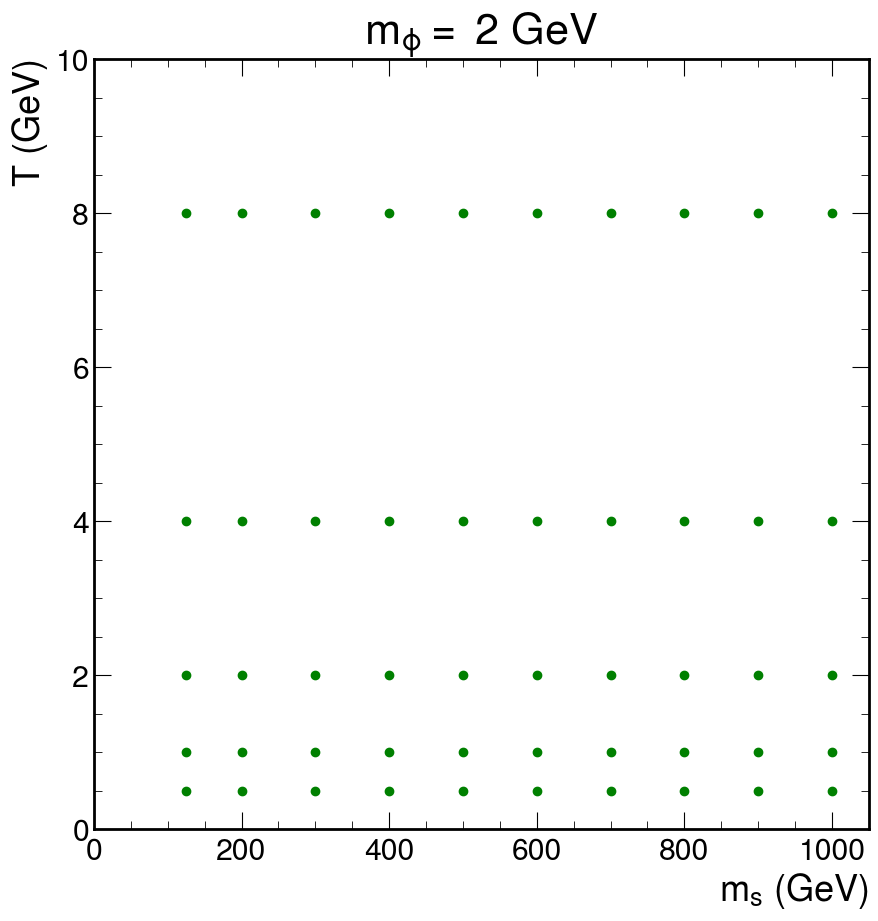

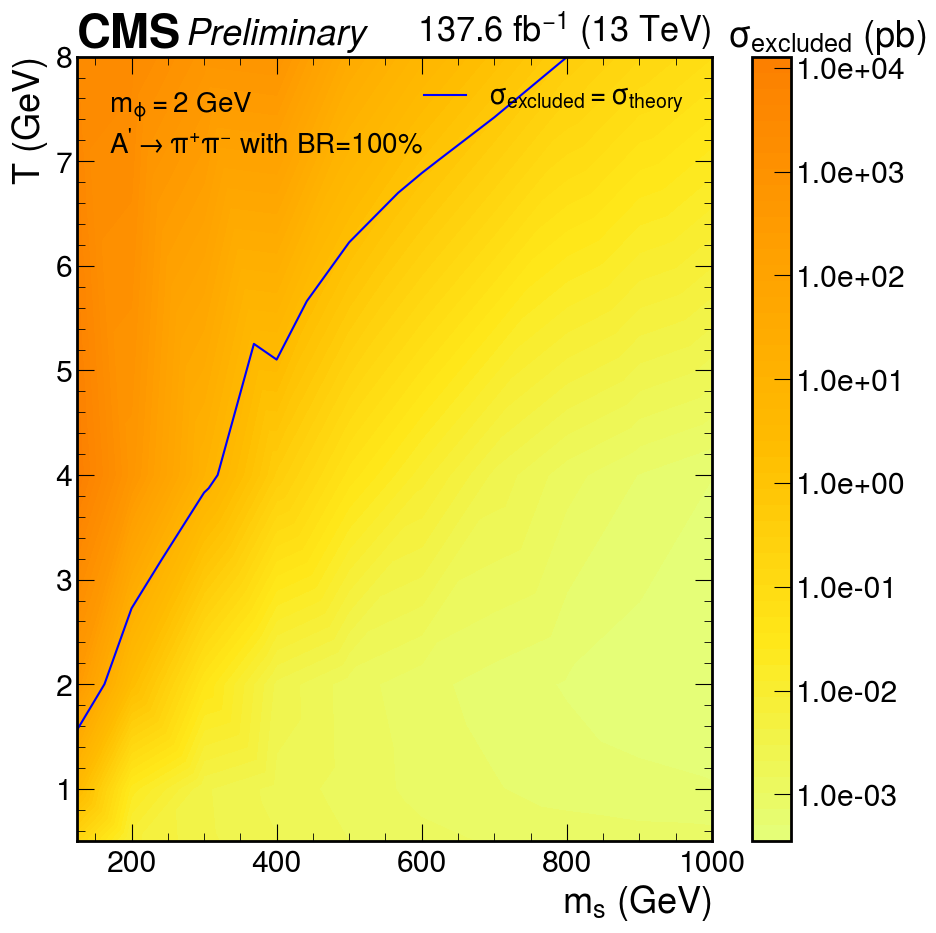

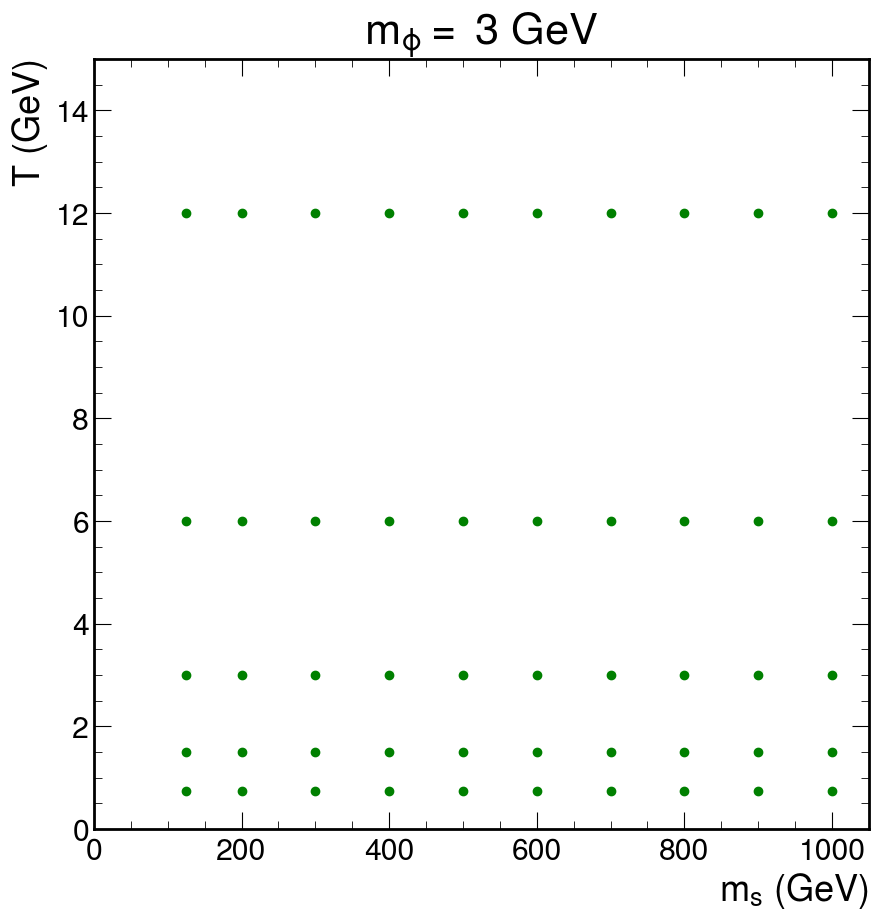

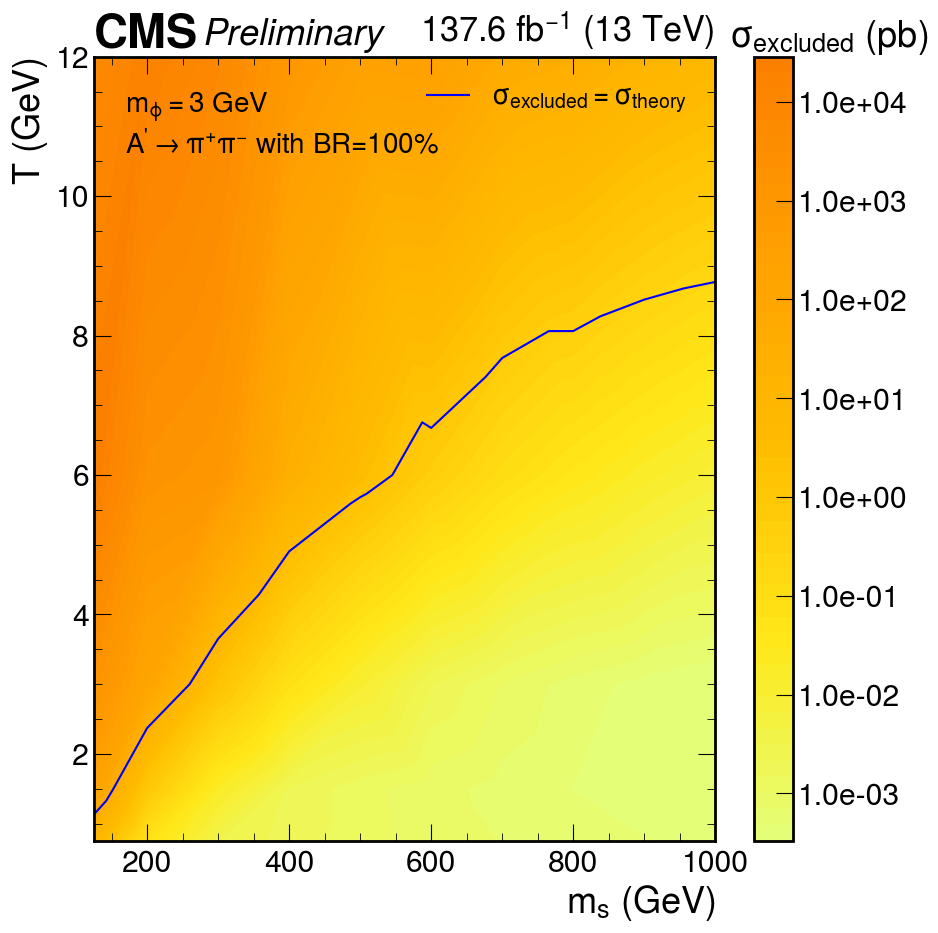

../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi4.000_T16.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


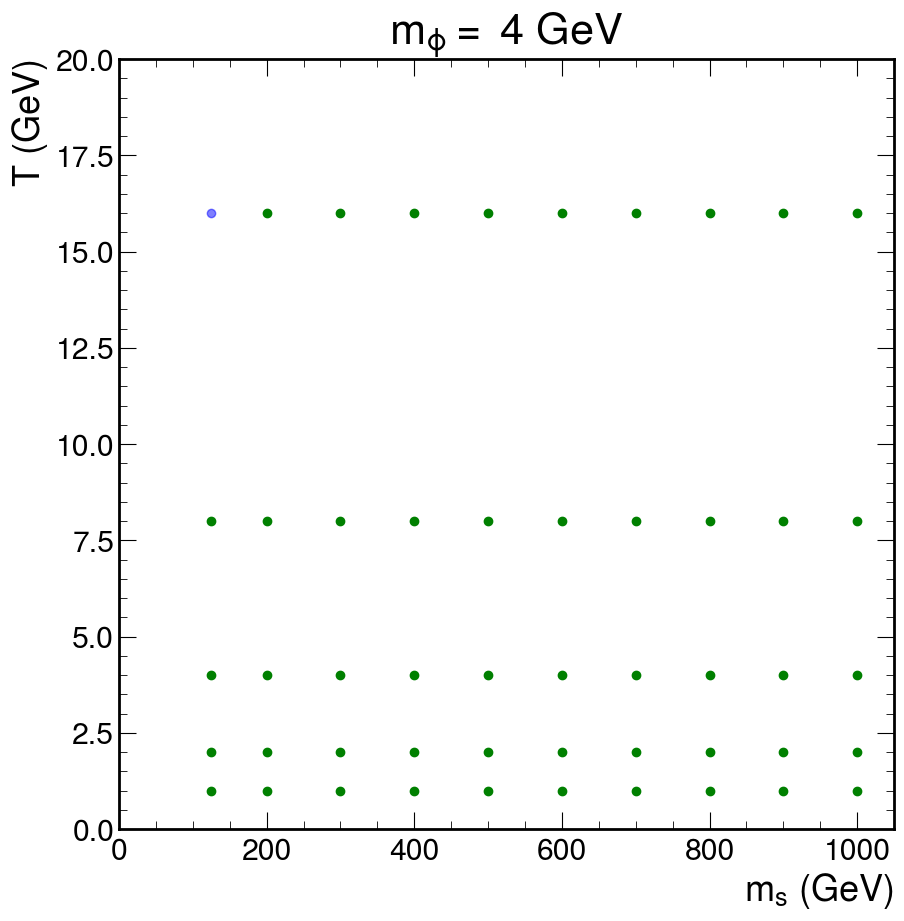

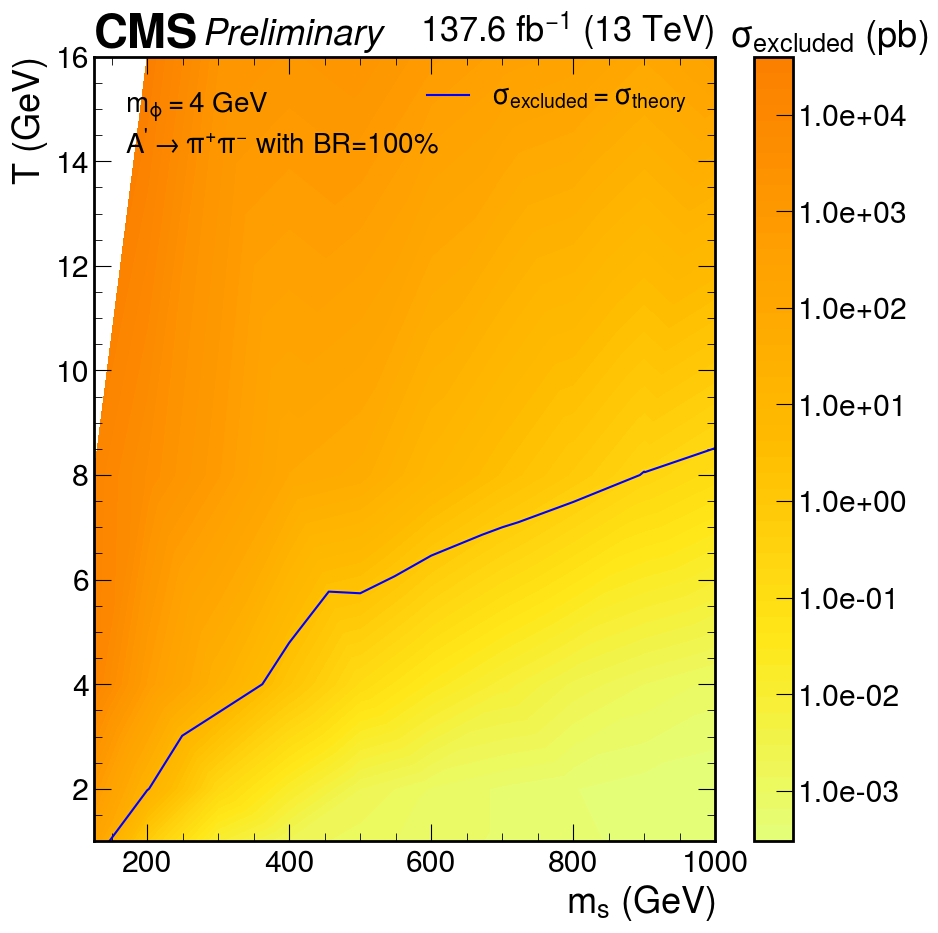

../higgsCombineGluGluToSUEP_HT1000_T32p0_mS200.000_mPhi8.000_T32.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi8.000_T16.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
../higgsCombineGluGluToSUEP_HT1000_T32p0_mS125.000_mPhi8.000_T32.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


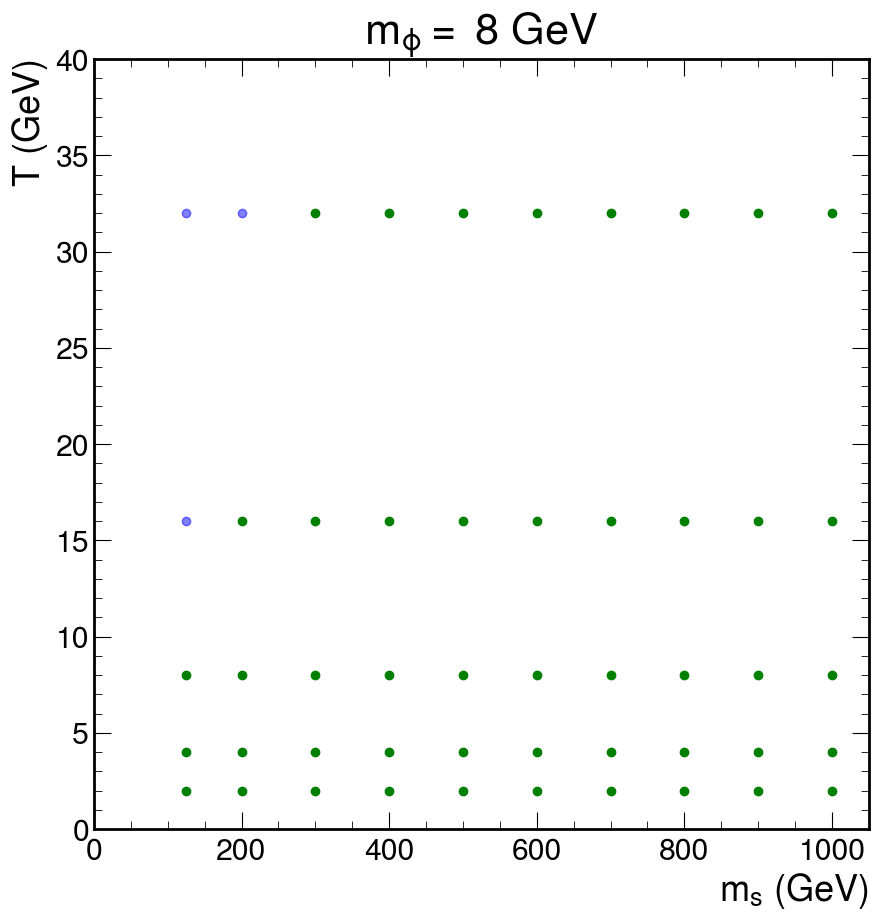

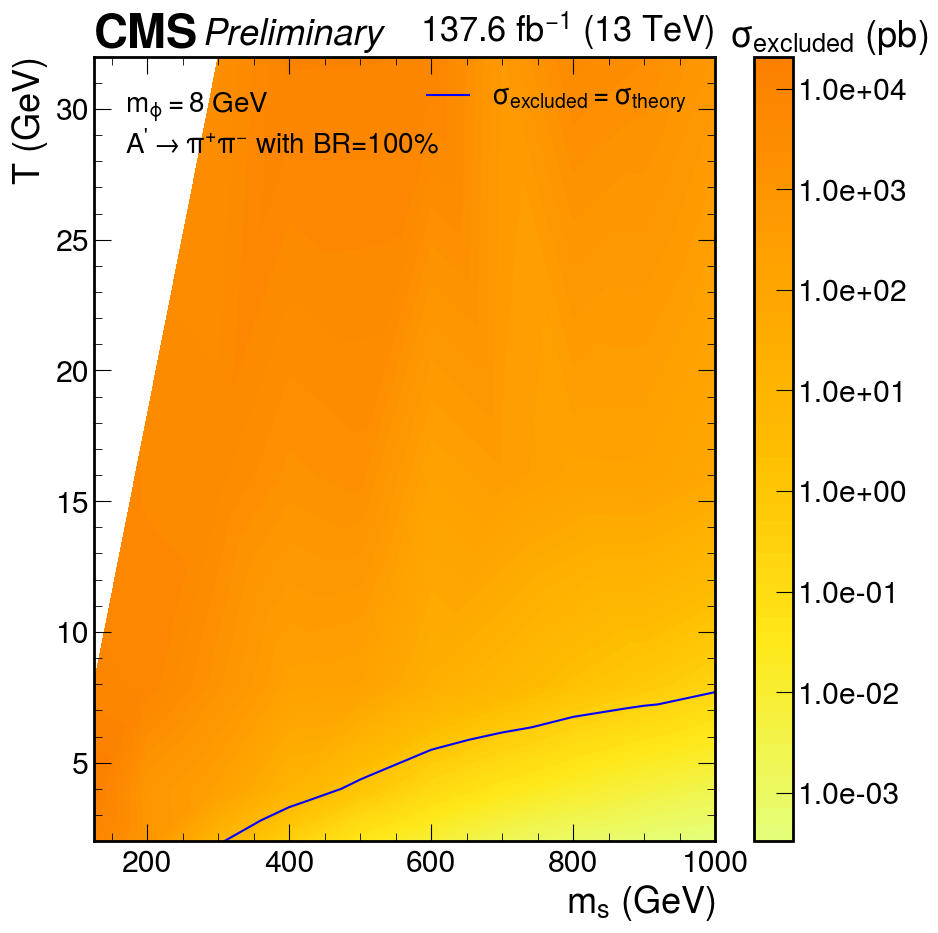

In [37]:
lines = []
mphis = {'generic':[2,3,4,8], 'hadronic':[1.4,2,3,4,8],'leptonic':[1,2,3,4,8]}
for mphi in mphis[decaymode]:
    lines.append(plot_SUEP(get_params(mphi)))

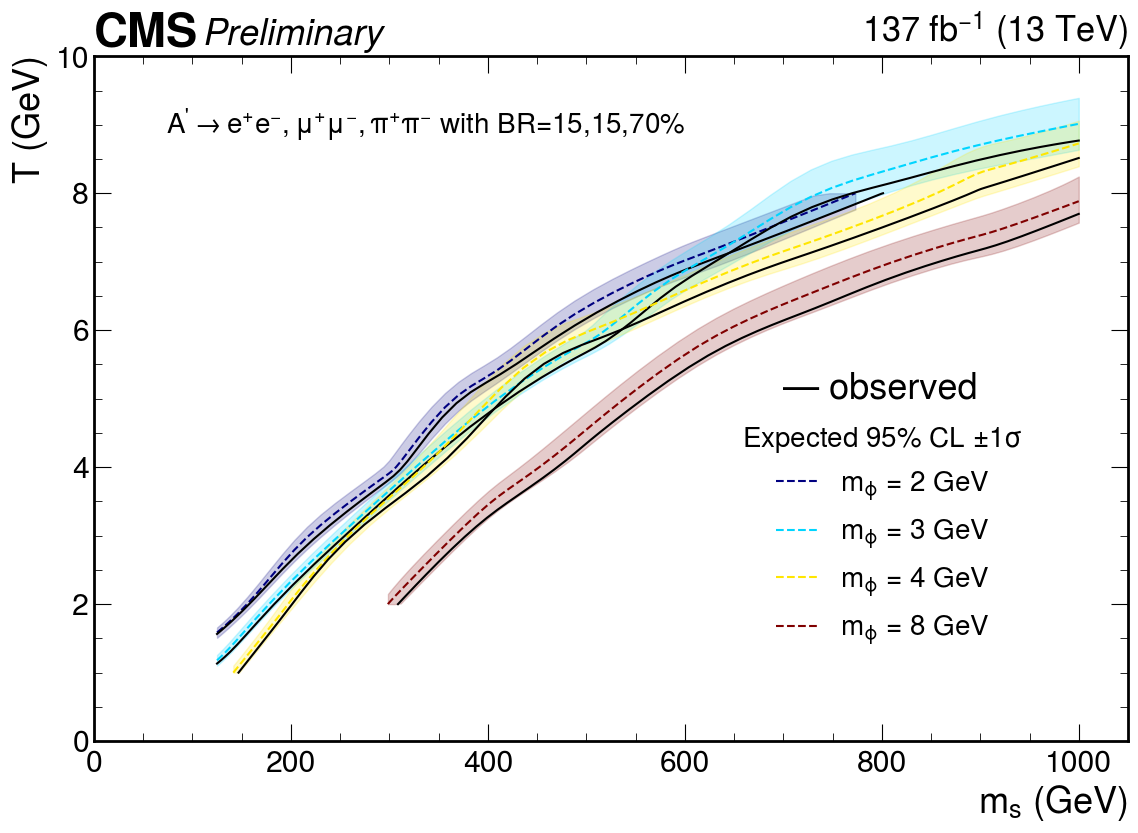

In [50]:
# Define colours
cmap = plt.cm.jet
colors = cmap(np.linspace(0., 1., 4))

masses = mphis[decaymode]

fig, ax = plt.subplots(figsize=(12,9))

for i, line in enumerate(lines):
    line1,line2,line3,line5 = line
    x1,y1 = interpLimit(line1, 2) #Expected $95\%$ CL
    x2,y2 = interpLimit(line2, 2)
    x3,y3 = interpLimit(line3, 2)
    x5,y5 = interpLimit(line5, 2)


    ax.plot(x2,y2,linestyle = '--', label=r"$m_{{\phi}}$ = {} GeV".format(masses[i]),c=colors[i])
    ax.plot(x5,y5, linestyle = '-',c='black')
    
    y1_interp = np.interp(x2, x1, y1)
    y3_interp = np.interp(x2, x3, y3)
    ax.fill_between(x2,y1_interp, y3_interp, color=colors[i],alpha=0.2)


# Annotate figure
ax.set_xlabel(r"$m_{s}$ (GeV)", x=1, ha='right')
ax.set_ylabel(r"$T$ (GeV)", y=1, ha='right')
hep.cms.label(llabel='Preliminary', data=False, lumi=137, ax=ax) # To add CMS lumi scripts
ax.text(600,9, r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$ with BR=15,15,70%", horizontalalignment='right', verticalalignment='center',fontsize=20)

ax.set_xlim([0., 1050])
ax.set_ylim([0,10 ])

legend = ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.3),frameon=False , fontsize=20, title= 'Expected 95% CL $\pm 1\sigma$')
legend.get_title().set_fontsize(20)
plt.text(700,5,'— observed')


plt.tight_layout()

# plt.savefig("/home/submit/pvanstee/public_html/SUEP/2D_summary_limits_{}_mphi.pdf".format(decaymode), bbox_inches='tight')
# plt.savefig("/home/submit/pvanstee/public_html/SUEP/2D_summary_limits_{}_mphi.png".format(decaymode), bbox_inches='tight')
